In [27]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg
import geopandas as gpd

## Exploratory Data Analysis 

#### Read data

In [28]:
df = pd.read_csv('train.csv')

In [29]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   House ID   500 non-null    int64  
 1   Bedrooms   500 non-null    int64  
 2   Bathrooms  500 non-null    float64
 3   Area       500 non-null    int64  
 4   Latitude   500 non-null    float64
 5   Longitude  500 non-null    float64
 6   Price      500 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 27.5 KB


,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
count,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,5.000000e+02
mean,250.500000,3.350000,2.669500,2369.64600,35.128844,-116.469049,5.980218e+05
std,144.481833,1.172283,1.017578,1208.18261,2.386173,6.554434,5.240649e+05
min,1.000000,1.000000,1.000000,701.00000,32.631500,-122.368300,2.200000e+04
25%,125.750000,2.000000,2.000000,1440.00000,33.808200,-119.802500,2.350000e+05
50%,250.500000,3.000000,2.500000,2097.50000,33.920800,-117.609600,5.300000e+05
75%,375.250000,4.000000,3.000000,3104.50000,35.640600,-116.371300,7.490000e+05
max,500.000000,10.000000,7.000000,9583.00000,47.791800,-87.885900,5.858000e+06


#### Plot graphs

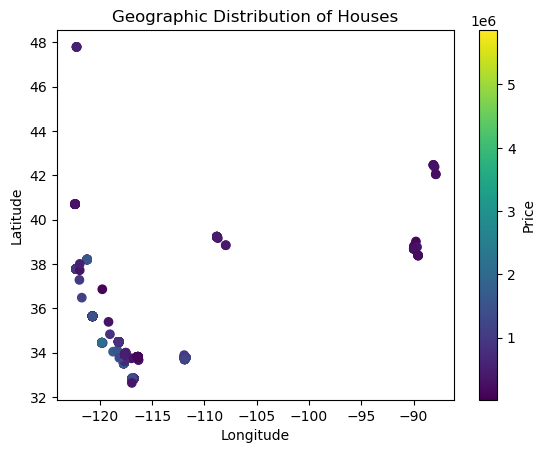

In [30]:
plt.scatter(df['Longitude'], df['Latitude'], 
            c=df['Price'], cmap='viridis')
plt.colorbar(label='Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Geographic Distribution of Houses")
plt.show()

<Figure size 1000x1000 with 0 Axes>

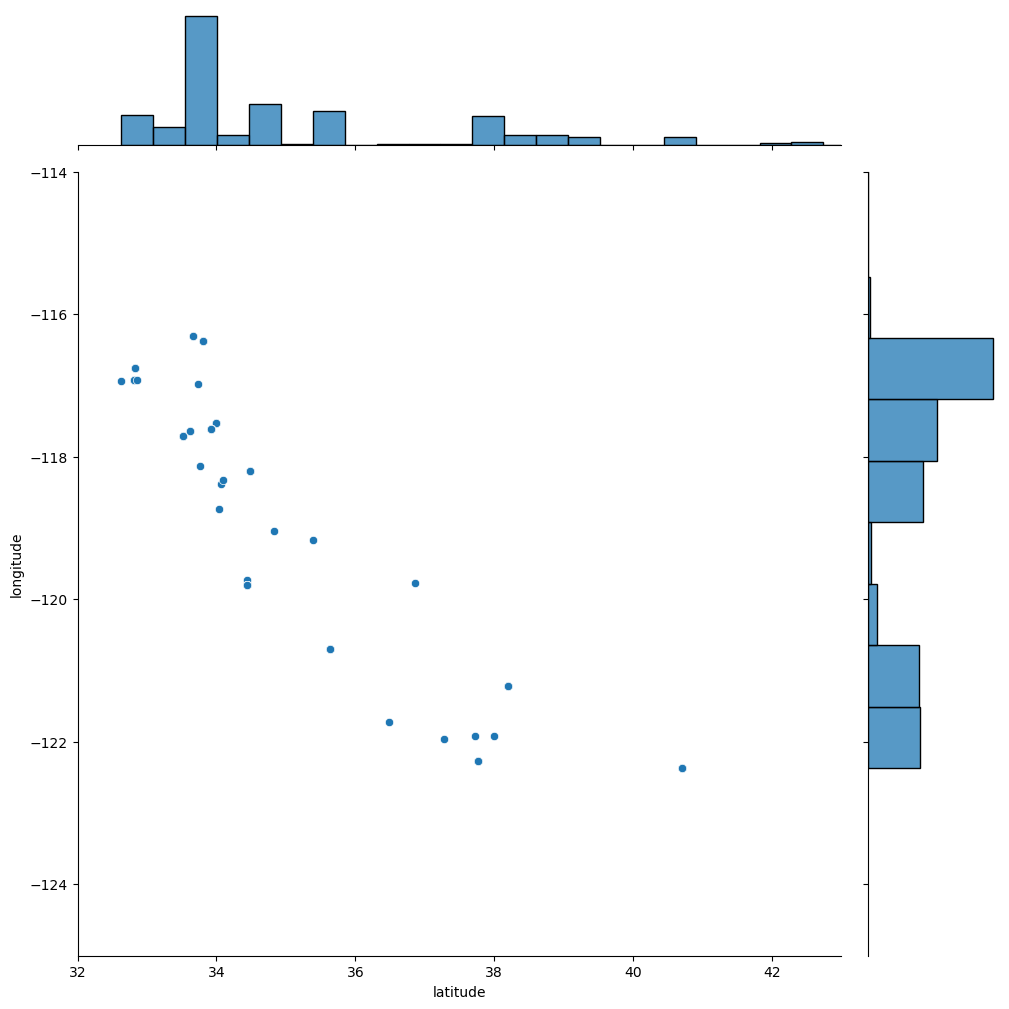

<Figure size 640x480 with 0 Axes>

In [31]:
plt.figure(figsize=(10,10))
sns.jointplot(x=df.Latitude.values, y=df.Longitude.values, xlim=(32,43), ylim=(-125,-114), height=10)
plt.ylabel("longitude")
plt.xlabel("latitude")
plt.show()
sns.despine()

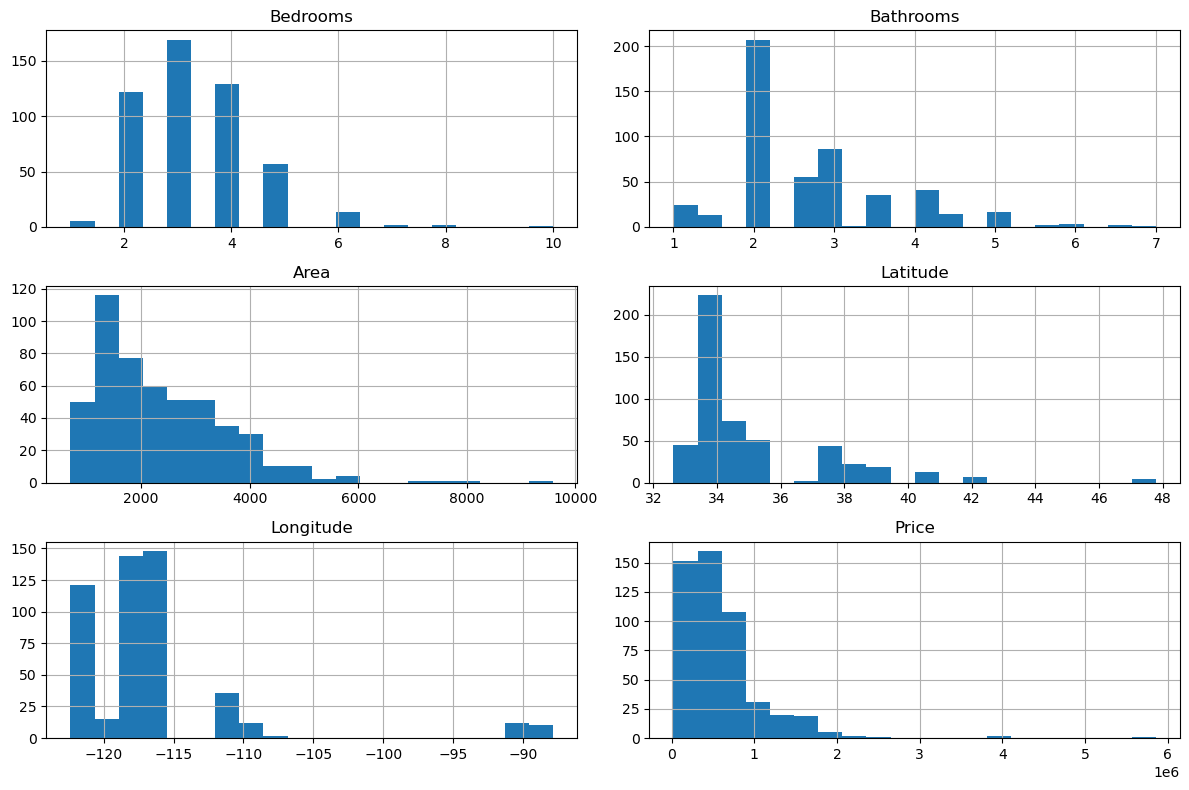

In [32]:
numeric_cols = ["Bedrooms", "Bathrooms", "Area", "Latitude", "Longitude", "Price"]
df[numeric_cols].hist(figsize=(12, 8), bins=20)
plt.tight_layout()
plt.show()


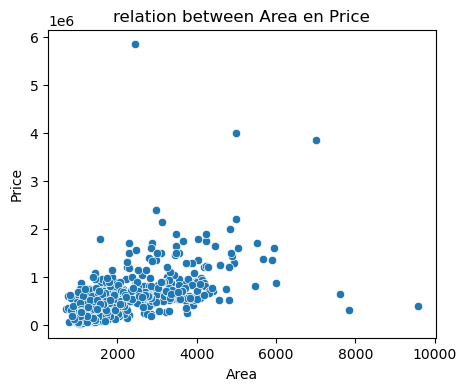

In [33]:
plt.figure(figsize=(5, 4))
sns.scatterplot(x="Area", y="Price", data=df)
plt.title("relation between Area en Price")
plt.show()


#### Correlations

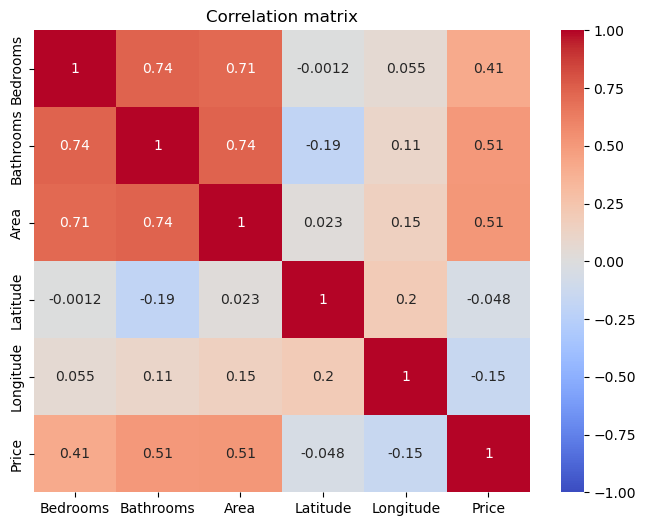

In [34]:
corr = df[numeric_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation matrix")
plt.show()


#### Outliers


In [35]:
Q1 = df["Price"].quantile(0.25)
Q3 = df["Price"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

outliers = df[(df["Price"] < lower_bound) | (df["Price"] > upper_bound)]
print("Amount of outliers :", outliers.shape[0])


Amount of outliers : 23


In [36]:
def display_house(house_id, df, folder='Train'):

    house_data = df.loc[df["House ID"] == house_id]
    if house_data.empty:
        print(f"House ID {house_id} Not Found")
        return
    
    num_bathrooms = house_data["Price"].values[0]
    filename = f"{house_id}.jpg"
    img_path = os.path.join(folder, filename)
    
    if not os.path.exists(img_path):
        print(f"File not found: {img_path}")
        return
    
    img = mpimg.imread(img_path)
    height, width, _ = img.shape
    

    plt.figure(figsize=(12,12))
    plt.imshow(img)
    plt.title(f"House ID: {house_id} - Price: ${num_bathrooms}", fontsize=14)
    plt.axis('off')
    
    plt.axvline(x=width/2, color='white', linewidth=2)
    plt.axhline(y=height/2, color='white', linewidth=2)

    plt.text(width*0.25, height*0.05, "Bathroom",
             color='white', fontsize=12, ha='center', va='top',
             bbox=dict(facecolor='black', alpha=0.5))
    plt.text(width*0.75, height*0.05, "Bedroom",
             color='white', fontsize=12, ha='center', va='top',
             bbox=dict(facecolor='black', alpha=0.5))
    plt.text(width*0.25, height*0.55, "Kitchen",
             color='white', fontsize=12, ha='center', va='top',
             bbox=dict(facecolor='black', alpha=0.5))
    plt.text(width*0.75, height*0.55, "Front view",
             color='white', fontsize=12, ha='center', va='top',
             bbox=dict(facecolor='black', alpha=0.5))

    plt.show()


display_house(1, df, folder='Train') # Display the house with ID 1, ID can be changed to any other ID


File not found: Train\1.jpg


In [37]:
house_ids = df["House ID"].values

In [40]:
!pip install opencv-python

   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/39.5 MB 4.1 MB/s eta 0:00:10
   - -------------------------------------- 1.9/39.5 MB 29.9 MB/s eta 0:00:02
   --- ------------------------------------ 3.4/39.5 MB 36.1 MB/s eta 0:00:02
   ------- -------------------------------- 7.8/39.5 MB 62.2 MB/s eta 0:00:01
   ---------- ----------------------------- 10.1/39.5 MB 64.4 MB/s eta 0:00:01
   -------------- ------------------------- 14.7/39.5 MB 93.0 MB/s eta 0:00:01
   -------------- ------------------------- 14.7/39.5 MB 93.0 MB/s eta 0:00:01
   -------------- ------------------------- 14.7/39.5 MB 93.0 MB/s eta 0:00:01
   -------------- ------------------------- 14.7/39.5 MB 93.0 MB/s eta 0:00:01
   -------------- ------------------------- 14.7/39.5 MB 93.0 MB/s eta 0:00:01
   -------------- ------------------------- 14.7/39.5 MB 93.0 MB/s eta 0:00:01
   -------------- ------------------------- 14.7/39.5 MB 93.0 MB/s

In [41]:

def load_and_preprocess_image(house_id, folder='Train', img_size=(224, 224)):

    filename = f"{house_id}.jpg"
    path = os.path.join(folder, filename)
    
    img = cv2.imread(path)               
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = img / 255.0
    return img


images = []
for hid in house_ids:
    img_array = load_and_preprocess_image(hid, folder='Train')
    images.append(img_array)

images = np.array(images)


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


Features for csv data

In [42]:
train = pd.read_csv('train.csv')

In [43]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


source  https://www.naturalearthdata.com/downloads/10m-physical-vectors/10m-coastline/

https://chatgpt.com/share/67dfde94-77f8-800b-93cc-ffa3c0778312


In [44]:
coastline = gpd.read_file("ne_10m_coastline.shp")
gdf_properties = gpd.GeoDataFrame(
    train,
    geometry=gpd.points_from_xy(df.Longitude, df.Latitude),
    crs="EPSG:4326"  # WGS84 Latitude/Longitude
)
gdf_properties = gdf_properties.to_crs(epsg=3857)
coastline = coastline.to_crs(epsg=3857)
train['distance_to_coast_m'] = gdf_properties.geometry.apply(
    lambda point: coastline.distance(point).min()
)

print(train.head())



c:\Users\Matt\anaconda3\Lib\site-packages\shapely\measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


   House ID  Bedrooms  Bathrooms  Area  Latitude  Longitude   Price  \
0         1         4        4.0  4053   33.6968  -111.8892  869500   
1         2         4        3.0  3343   34.8280  -119.0349  865200   
2         3         3        4.0  3923   33.7669  -111.9182  889000   
3         4         5        5.0  4022   33.7752  -111.7791  910000   
4         5         3        4.0  4116   33.7669  -111.9182  971226   

   distance_to_coast_m  
0        350887.562039  
1         77530.449791  
2        356761.999625  
3        366151.192977  
4        356761.999625  


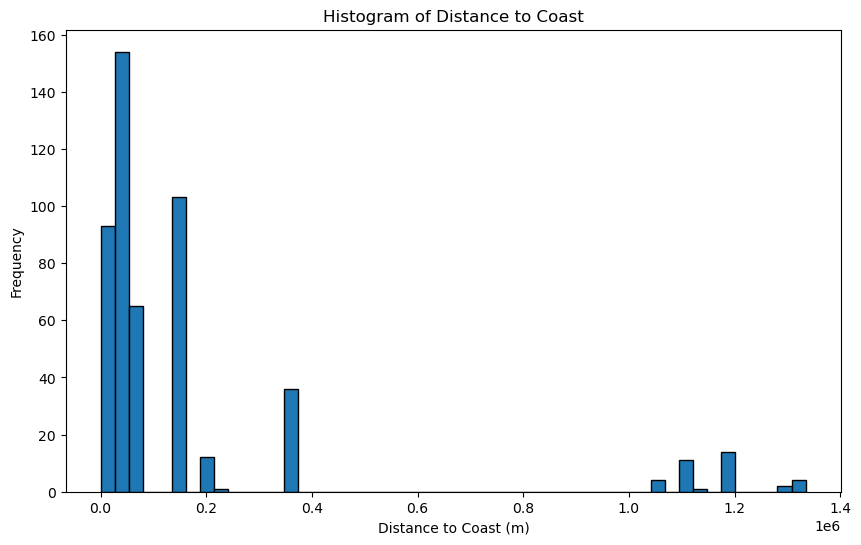

In [45]:
plt.figure(figsize=(10, 6))
plt.hist(train['distance_to_coast_m'], bins=50, edgecolor='black')
plt.title('Histogram of Distance to Coast')
plt.xlabel('Distance to Coast (m)')
plt.ylabel('Frequency')
plt.show()

In [46]:
from sklearn.cluster import KMeans
distances = np.array(train['distance_to_coast_m'])
distances_reshaped = distances.reshape(-1, 1)

# fit KMeans with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=0).fit(distances_reshaped)
labels = kmeans.labels_

# Create a new column in 'train' to store cluster labels
train['cluster'] = labels

# Compute mean distance for each cluster
cluster_0 = train[train['cluster'] == 0]['distance_to_coast_m']
cluster_1 = train[train['cluster'] == 1]['distance_to_coast_m']

mean_0 = cluster_0.mean()
mean_1 = cluster_1.mean()

print("Mean distance of cluster 0:", mean_0)
print("Mean distance of cluster 1:", mean_1)

mean_prices = train.groupby('cluster')['Price'].mean()
print(mean_prices)


Mean distance of cluster 0: 89295.972066417
Mean distance of cluster 1: 1165174.2876889803
cluster
0    619745.497845
1    318027.750000
Name: Price, dtype: float64


c:\Users\Matt\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [ ]:
train

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price,distance_to_coast_m,cluster
0,1,4,4.0,4053,33.6968,-111.8892,869500,350887.562039,0
1,2,4,3.0,3343,34.8280,-119.0349,865200,77530.449791,0
2,3,3,4.0,3923,33.7669,-111.9182,889000,356761.999625,0
3,4,5,5.0,4022,33.7752,-111.7791,910000,366151.192977,0
4,5,3,4.0,4116,33.7669,-111.9182,971226,356761.999625,0
...,...,...,...,...,...,...,...,...,...
495,496,2,2.0,1257,35.6406,-120.7003,380000,35044.294143,0
496,497,4,2.0,2072,35.6406,-120.7003,429900,35044.294143,0
497,498,2,2.0,2213,35.6406,-120.7003,585000,35044.294143,0
498,499,3,2.5,1500,35.6406,-120.7003,319000,35044.294143,0


## Convolutional Neural Network

- In deze deelopdracht werk je alleen met de afbeeldingen en labels, en niet met de rest van de tabeldata. Bouw een convolutioneel neuraal netwerkmodel om de prijzen te voorspellen op basis van de afbeeldingen.


Plot je modelarchitectuur met behulp van een geschikte visualisatietool.

In [93]:
import pathlib
import tensorflow as tf

# Define paths using pathlib
cnn__train_df = pathlib.Path("Train/")  # Fix the empty string to "Train/"
cnn_test_df = pathlib.Path("Test/")

# Hyperparameters
batch_size = 32
img_height = 180
img_width = 180

# Load Train dataset (split into training and validation)
train_ds = tf.keras.utils.image_dataset_from_directory(
    cnn__train_df,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    cnn__train_df,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Load Test dataset (no validation split)
test_ds = tf.keras.utils.image_dataset_from_directory(
    cnn_test_df,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Print dataset details
print(f"Train batches: {len(train_ds)}, Validation batches: {len(val_ds)}, Test batches: {len(test_ds)}")


Found 500 files belonging to 1 classes.
Using 400 files for training.
Found 500 files belonging to 1 classes.
Using 100 files for validation.
Found 35 files belonging to 1 classes.
Train batches: 13, Validation batches: 4, Test batches: 2


In [169]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

# Load CSV
df = pd.read_csv("train.csv")

# Define image size (e.g., 224x224 for ResNet or MobileNet)
IMG_SIZE = (224, 224)
IMG_DIR = "train/house"

# Load images and labels
def load_image(filename):
    path = os.path.join(IMG_DIR, f"{str(filename)}.jpg")  # Ensure filename is a string
    img = load_img(path, target_size=IMG_SIZE)  # Resize image
    img = img_to_array(img) / 255.0  # Normalize
    return img

# Apply the function
X = np.array([load_image(f) for f in df["House ID"]])
y = np.array(df["Price"])  # Regression target

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

 

In [173]:
from sklearn.preprocessing import MinMaxScaler

# Reshape your target labels to 2D for scaling
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)

y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001EC19AED9E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step 


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 486ms/step - loss: 1.4870 - mean_absolute_error: 0.0901 - val_loss: 0.5238 - val_mean_absolute_error: 0.0539
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 467ms/step - loss: 0.4013 - mean_absolute_error: 0.0570 - val_loss: 0.2416 - val_mean_absolute_error: 0.0546
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 455ms/step - loss: 0.2061 - mean_absolute_error: 0.0616 - val_loss: 0.1233 - val_mean_absolute_error: 0.0547
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 472ms/step - loss: 0.1090 - mean_absolute_error: 0.0590 - val_loss: 0.0671 - val_mean_absolute_error: 0.0538
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 448ms/step - loss: 0.0601 - mean_absolute_error: 0.0535 - val_loss: 0.0394 - val_mean_absolute_error: 0.0663
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 453ms/step - loss: 0.0373 - mean_absolute_error: 0.0605 - val_loss: 0.0235 - val_mean_absolute_error: 0.0535
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 452ms/step - loss: 0.0265 - mean_absolute_error: 0.0

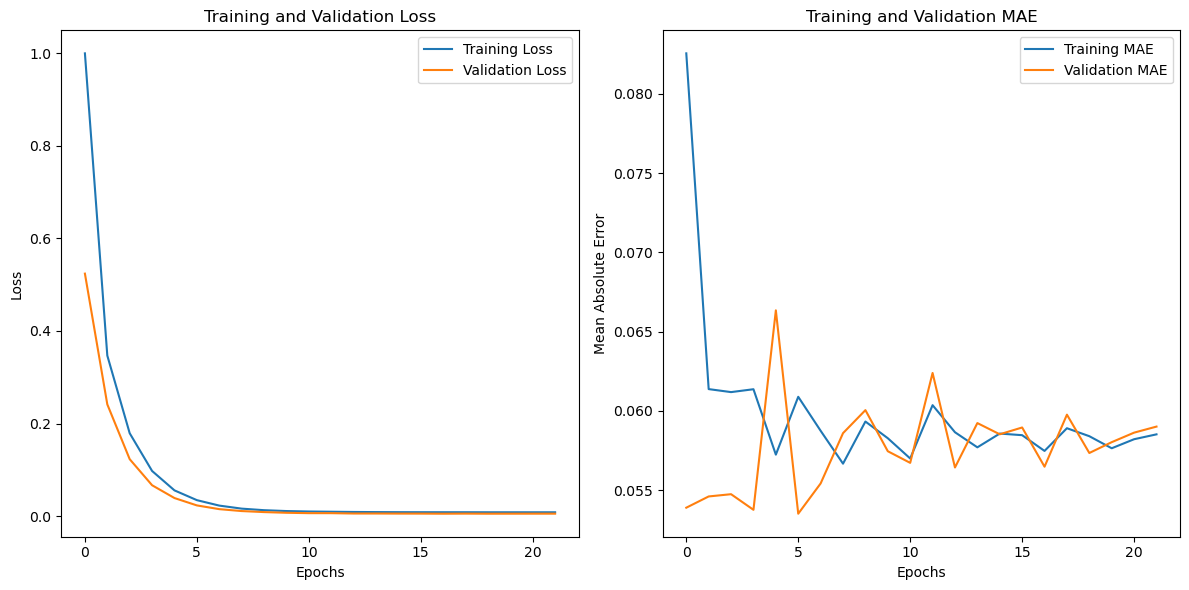

In [178]:
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
# Define Model

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),

    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(1)
])
# Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mse", metrics=["mean_absolute_error"])

# Define EarlyStopping Callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Fit the model and store the training history
history = model.fit(X_train, y_train_scaled, epochs=100, batch_size=32, validation_data=(X_test, y_test_scaled), callbacks=[stop_early])

# Plotting training and validation loss and MAE
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot training and validation mean absolute error
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')

plt.tight_layout()
plt.show()


In [141]:
# Evaluate model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae}")

# Predict
predictions = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 174515519488.0000 - mae: 319344.3125
Test MAE: 331068.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


In [ ]:
# Get image ids from test set and convert to unicode
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

# Write the submission file
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)